## Install master branches of theano and lasagne
[Here are the instructions](http://lasagne.readthedocs.io/en/latest/user/installation.html#bleeding-edge-version)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pymc3 as pm
import theano.tensor as tt
import theano

from scipy.stats import mode, chisquare
from sklearn.metrics import confusion_matrix, accuracy_score
import lasagne

In [3]:
#(u'1.0.1', '0.2.dev1')
theano.__version__, lasagne.__version__


(u'1.0.1', '0.2.dev1')

In [4]:
import sys, os
def load_dataset():
    #support both python 2 and 3
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve
    
    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print ("Downloading %s" % filename)
        urlretrieve(source + filename, filename)
    
    #Load MNIST images and labels
    import gzip
    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
            #reshape the vectors to 2D monochrome images
            #shape convention (examples, channels, rows, columns)
            data = data.reshape(-1, 1, 28, 28)
            #bytes to float [0, 256]
            return data / np.float32(256)
    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
            #labels are vectors of integers
        return data
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')
    
    #Split train-validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()


In [5]:
X_train.shape, y_train.shape

((50000, 1, 28, 28), (50000,))

In [46]:
#theano shared vars
input_var = theano.shared(X_train[:500, ...].astype(np.float64))
target_var = theano.shared(y_train[:500, ...].astype(np.float64))


## Model specification

In [4]:
def build_ann(init):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
    l_hid1 = lasagne.layers.DenseLayer(l_in, num_units=25, nonlinearity=lasagne.nonlinearities.tanh,
                                      b=init,
                                      W=init)
    l_hid2 = lasagne.layers.DenseLayer(l_hid1, num_units=25, nonlinearity=lasagne.nonlinearities.tanh,
                                      b=init,
                                      W=init)
    #Final layer of 10 units, softmax across 10 labels
    l_out = lasagne.layers.DenseLayer(l_hid2, num_units=10, nonlinearity=lasagne.nonlinearities.softmax,
                                     b=init,
                                     W=init)
    prediction = lasagne.layers.get_output(l_out)
    #categorical distribution
    out = pm.Categorical('out', p=prediction, observed=target_var)
    return out


## Priors

In [5]:
class GaussianWeights(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        return pm.Normal('w%d' % self.count, 
                         mu=0, 
                         sd=.1,
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)
    

## Tensors and RVs for mini-batches

In [47]:
#ADVI minibatches
#
from six.moves import zip
minibatch_tensors = [input_var, target_var]
def create_minibatch(data, batchsize=500):
    rng = np.random.RandomState(0)
    start_idx = 0
    #Return random samples of batchsize on each iteration
    while True:
        ixs = rng.randint(data.shape[0], size=batchsize)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train, 500), 
    create_minibatch(y_train, 500)
)
total_size = len(y_train)

def run_advi(likelihood, advi_iters=50000):
    #Train
    input_var.set_value(X_train[:500, ...])
    target_var.set_value(y_train[:500, ...])
    v_params = pm.variational.advi_minibatch(
        n=advi_iters,
        minibatch_tensors=minibatch_tensors,
        minibatch_RVs=[likelihood], 
        minibatches=minibatches,
        total_size=total_size,
        learning_rate=1e-2,
        epsilon=1.0
    )

    trace = pm.variational.sample_vp(v_params, draws=500)
    
    #Predict on test data
    input_var.set_value(X_test)
    target_var.set_value(y_test)
    
    ppc = pm.sample_ppc(trace, samples=100)
    y_pred = mode(ppc['out'], axis=0).mode[0, :]
    
    return v_params, trace, ppc, y_pred

## Now put them together

In [20]:
with pm.Model() as neural_net:
    likelihood = build_ann(GaussianWeights())
    v_params, trace, ppc, y_pred = run_advi(likelihood)

Average ELBO = -20,115.25: 100%|██████████| 50000/50000 [05:31<00:00, 150.69it/s]
Finished minibatch ADVI: ELBO = -19,440.40
/Users/vmullachery/anaconda/envs/dl2.7/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
100%|██████████| 100/100 [00:20<00:00,  5.04it/s]


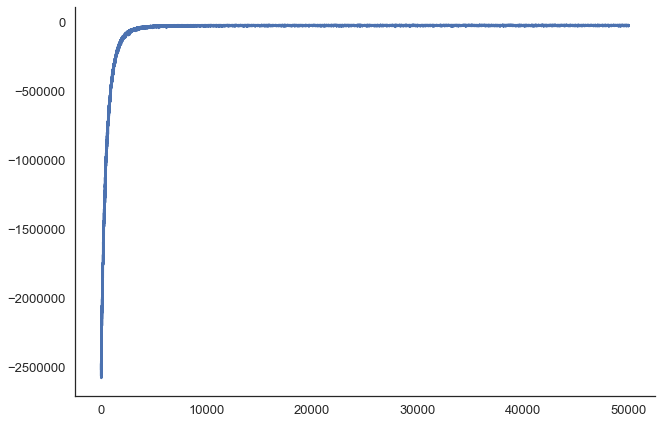

In [23]:
plt.plot(v_params.elbo_vals)
sns.despine()

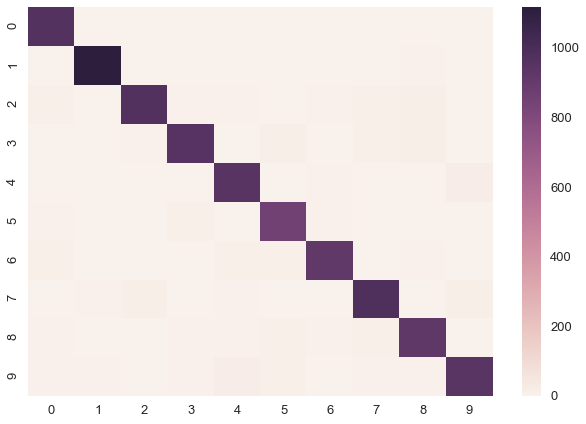

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [25]:
print("Accuracy on test: {}".format(accuracy_score(y_test, y_pred)*100))

Accuracy on test: 95.88


## Hierarchical Neural Network: Learning Regularization from data

In [48]:
from six.moves import zip
class GaussWeightWithHR(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        regularization = pm.HalfNormal('reg_hyper%d' % self.count, sd=1)
        return pm.Normal('w%d'%self.count, 
                         mu=0, 
                         sd=regularization, 
                         testval=np.random.normal(size=shape),
                         shape=shape)
minibatches = zip(
    create_minibatch(X_train, 500),
    create_minibatch(y_train, 500)
)


In [34]:
with pm.Model() as hnn:
    likelihood = build_ann(GaussWeightWithHR())
    v_params, trace, ppc, y_pred = run_advi(likelihood)

Average ELBO = -20,802.87: 100%|██████████| 50000/50000 [05:57<00:00, 139.92it/s]
Finished minibatch ADVI: ELBO = -19,799.87
/Users/vmullachery/anaconda/envs/dl2.7/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


In [37]:
print("Accuracy on test: {}".format(accuracy_score(y_test, y_pred)*100))

Accuracy on test: 95.07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137b5a910>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121fd0cd0>]], dtype=object)

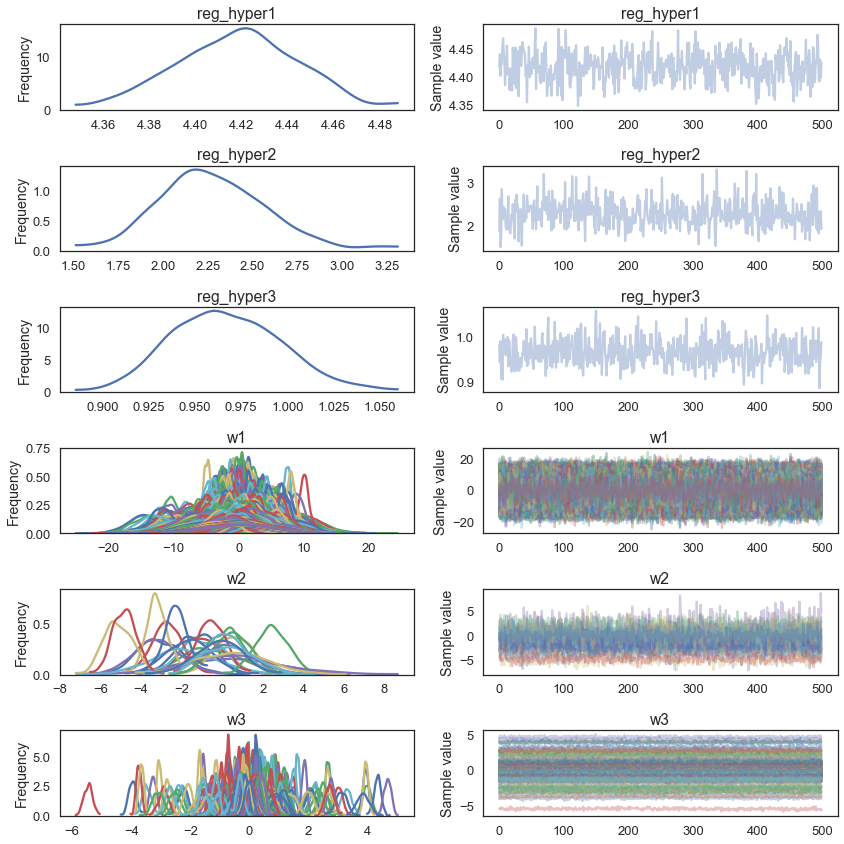

In [39]:
pm.traceplot(trace, varnames=['reg_hyper1', 'reg_hyper2', 'reg_hyper3', 'w2'])

In [38]:
trace.varnames

['w1',
 'w2',
 'w3',
 'w4',
 'w5',
 'w6',
 'reg_hyper1',
 'reg_hyper2',
 'reg_hyper3',
 'reg_hyper4',
 'reg_hyper5',
 'reg_hyper6']

## Now a Convolutional Net
All it requires is that we change the build_ann method to include convolutional layers

In [49]:
def build_ann_conv(init):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
    network = lasagne.layers.Conv2DLayer(network, 
                                      num_filters=32, 
                                      filter_size=(5,5),
                                      nonlinearity=lasagne.nonlinearities.tanh,
                                      W=init
                                     )
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2,2))
    network = lasagne.layers.Conv2DLayer(network,
                                        num_filters=32,
                                        filter_size=(5,5),
                                        nonlinearity=lasagne.nonlinearities.tanh,
                                        W=init)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2,2))
    network = lasagne.layers.DenseLayer(network, 
                                        num_units=256, 
                                        nonlinearity=lasagne.nonlinearities.tanh,
                                        b=init,
                                        W=init
                                       )
    network = lasagne.layers.DenseLayer(network,
                                       num_units=10,
                                       nonlinearity=lasagne.nonlinearities.softmax,
                                       b=init,
                                       W=init)
    prediction = lasagne.layers.get_output(network)
    
    return pm.Categorical('out', prediction, observed=target_var)

In [50]:
with pm.Model() as cnn:
    likelihood = build_ann_conv(GaussWeightWithHR())
    v_params, trace, ppc, y_pred = run_advi(likelihood)

Average ELBO = -30,085.04: 100%|██████████| 50000/50000 [36:55:44<00:00,  1.02it/s]         
Finished minibatch ADVI: ELBO = -28,966.46
/Users/vmullachery/anaconda/envs/dl2.7/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
100%|██████████| 100/100 [11:23<00:00,  6.73s/it]


In [51]:
print("Accuracy on test: {}".format(accuracy_score(y_test, y_pred)*100))

Accuracy on test: 96.97


### Unpredictability on categorical distribution measured using Chi-squared statistic
We don't simply use the ppc standard deviation

In [52]:
miss_class = np.where(y_test != y_pred)[0]
corr_class = np.where(y_test == y_pred)[0]
preds = pd.DataFrame(ppc['out']).T
chis = preds.apply(lambda x: chisquare(x).statistic, axis='columns')

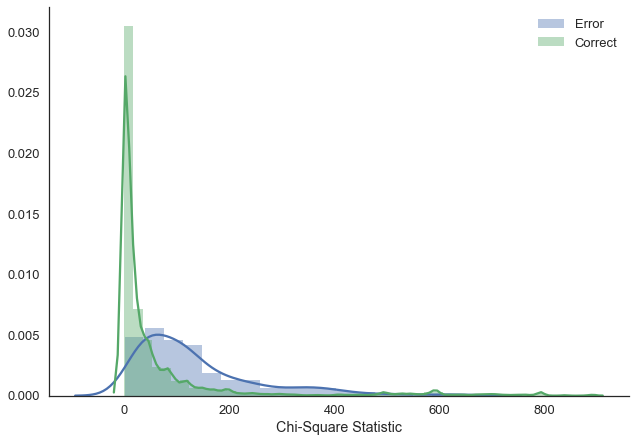

In [54]:
sns.distplot(chis.loc[miss_class].dropna(), label='Error')
sns.distplot(chis.loc[corr_class].dropna(), label='Correct')
plt.legend()
sns.despine()
plt.xlabel('Chi-Square Statistic')